## `Animal Recognition`

In [95]:
# Import the relevant libraries
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import cv2 as cv

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.metrics import Precision, Recall

In [3]:
# Train & Test directories
train_dir = "archive/train"
test_dir = "archive/test"

In [4]:
# Define ImageDataGenerator and specify augmentation parameters if needed
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # Set target size for images
    batch_size=22500,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64,64),
    batch_size=6500,
    class_mode = 'categorical'
)

# Dataset
train_imgs, train_label = next(train_generator)
test_imgs, test_label = next(test_generator)

Found 22566 images belonging to 80 classes.
Found 6505 images belonging to 80 classes.


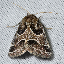

In [13]:
# Inspect image on index 20
array_to_img(train_imgs[20])

In [6]:
# Function for getting dataset shapes
class Shape():
    """Primary parameters"""
    def __init__(self, train_images, train_labels, test_images, test_labels):
        self.train_images = train_images
        self.train_labels = train_labels
        self.test_images = test_images
        self.test_labels = test_labels
   
    """Function for images"""
    def image_shape(self):
        # Return  the outputs
        return {"train_images_shape:":self.train_images.shape},{"test_images_shape:":self.test_images.shape}
       
    """Function for labels"""
    def label_shape(self):
        # Return the outputs
        return {"train_labels_shape:":self.train_labels.shape},{"test_labels_shape:":self.test_labels.shape}

    """For both outputs"""
    def output(self):
        return self.image_shape(), self.label_shape()
    
# Apply the function on the data
data_shape = Shape(train_imgs, train_label, test_imgs, test_label)
data_shape.output()

(({'train_images_shape:': (22500, 64, 64, 3)},
  {'test_images_shape:': (6500, 64, 64, 3)}),
 ({'train_labels_shape:': (22500, 80)}, {'test_labels_shape:': (6500, 80)}))

In [7]:
# Reshape the images 
train_imgs_reshaped = train_imgs.reshape(22500, -1)
test_imgs_reshaped = test_imgs.reshape(6500, -1)

# Inspect
imgs_shape = Shape(train_imgs_reshaped, train_label, test_imgs_reshaped, test_label)
imgs_shape.image_shape()

({'train_images_shape:': (22500, 12288)},
 {'test_images_shape:': (6500, 12288)})

- `Inspect the labels`

In [8]:
print("Train Labels:")
train_label[:5]

Train Labels:


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [64]:
# Specific data labels using train_indices of the generator
class_indices_train = train_generator.class_indices
class_indices_test = test_generator.class_indices

In [66]:
# Reverse one-hot-encoding
decoded_train = np.argmax(train_label, axis=1)
decoded_test = np.argmax(test_label, axis=1)
                    
# Class labels
class_labels = [
   'Bear', 'Brown bear', 'Bull', 'Butterfly', 'Camel', 'Canary', 'Caterpillar', 'Cattle', 
   'Centipede', 'Cheetah', 'Chicken', 'Crab', 'Crocodile', 'Deer', 'Duck', 'Eagle', 'Elephant',
    'Fish', 'Fox', 'Frog', 'Giraffe', 'Goat', 'Goldfish', 'Goose', 'Hamster', 'Harbor seal', 
    'Hedgehog', 'Hippopotamus', 'Horse', 'Jaguar', 'Jellyfish', 'Kangaroo', 'Koala', 'Ladybug', 
    'Leopard', 'Lion', 'Lizard', 'Lynx', 'Magpie', 'Monkey', 'Moths and butterflies', 'Mouse', 
    'Mule', 'Ostrich', 'Otter', 'Owl', 'Panda', 'Parrot', 'Penguin', 'Pig', 'Polar bear', 
    'Rabbit', 'Raccoon', 'Raven', 'Red panda', 'Rhinoceros', 'Scorpion', 'Sea lion', 
    'Sea turtle', 'Seahorse', 'Shark', 'Sheep', 'Shrimp', 'Snail', 'Snake', 'Sparrow', 'Spider', 
    'Squid', 'Squirrel', 'Starfish', 'Swan', 'Tick', 'Tiger', 'Tortoise', 'Turkey', 'Turtle', 
    'Whale', 'Woodpecker', 'Worm', 'Zebra'
    ]

# Mapping indices back to labels
decoded_labels_train= [class_labels[index] for index in decoded_train]
decoded_labels_test = [class_labels[index] for index in decoded_test]

print("train set decoded:", decoded_labels_train[:5]) # Display the first 5 decoded labels
print("test set decoded:", decoded_labels_test[:5])

train set decoded: ['Eagle', 'Lion', 'Whale', 'Eagle', 'Horse']
test set decoded: ['Goat', 'Ostrich', 'Tortoise', 'Spider', 'Polar bear']


In [68]:
# Label counts
label_counts = {label:decoded_labels_train.count(label) for label in set(decoded_labels_train)}

# Sort the labels
sorted__top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:10]
sorted_counts = {label:label_counts[label] for label in sorted__top_labels}
sorted_counts

{'Butterfly': 1866,
 'Moths and butterflies': 1427,
 'Lizard': 1195,
 'Spider': 856,
 'Fish': 832,
 'Monkey': 768,
 'Eagle': 719,
 'Frog': 586,
 'Snake': 561,
 'Duck': 540}

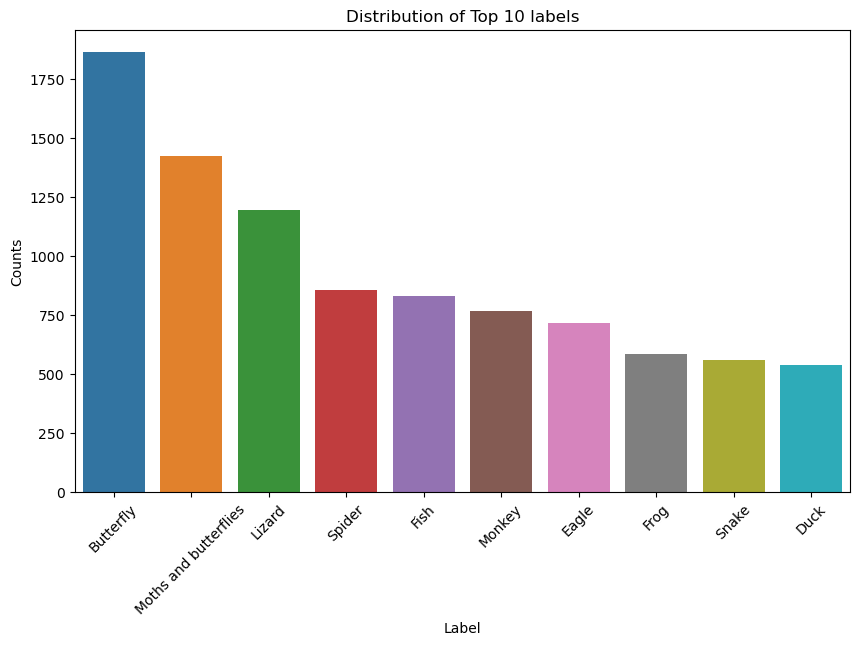

In [69]:
# Visualize the number of each image classification
fig, ax = plt.subplots(figsize=(10,6))

# Label distribution
labels = list(sorted_counts.keys())
counts = list(sorted_counts.values())
sns.barplot(x=labels, y=counts)
ax.set_xlabel("Label")
ax.set_ylabel("Counts")
ax.set_title("Distribution of Top 10 labels")
ax.tick_params(axis="x", labelrotation=45)

- `The most frequent class in the traning set is for Butterfly as shown in the distribution above.`

## `Data Preprocessing`

In [77]:
# Label encoding
encoder = LabelEncoder()
train_label_final = encoder.fit_transform(decoded_labels_train).reshape(-1,1)
test_label_final = encoder.transform(decoded_labels_test).reshape(-1,1)

In [80]:
# Apply the labe function to check on data shape
label_shape = Shape(train_imgs_reshaped, train_label_final, train_imgs_reshaped, test_label_final)
label_shape.label_shape()

({'train_labels_shape:': (22500, 1)}, {'test_labels_shape:': (6500, 1)})

- `The data is now ready for modelling.`

## `Modelling`

- `1. Baseline Dense Neural Net`

In [96]:
# Sequential model
model = Sequential() 

# Input layer with 80 layers and sigmoid activation function
model.add(layers.Dense(80, activation="sigmoid", input_shape=(12288,)))

# Hidden layer of 100 units
model.add(layers.Dense(100, activation="sigmoid"))

# Output layer
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=[Precision()]
              )

# Fit the model
results = model.fit(train_imgs_reshaped,
                    train_label_final,
                    batch_size=15,
                    epochs=5,
                    validation_data=(test_imgs_reshaped, test_label_final)
                    )

2023-12-12 22:03:54.707684: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.


Epoch 1/5


/home/kinoti/anaconda3/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(15, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1500/1500 [==============================] - ETA: 0s - loss: 0.0000e+00 - precision: 0.9961

2023-12-12 22:04:23.617090: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 319488000 exceeds 10% of free system memory.
/home/kinoti/anaconda3/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1500/1500 [==============================] - 29s 19ms/step - loss: 0.0000e+00 - precision: 0.9961 - val_loss: 0.0000e+00 - val_precision: 0.9940
Epoch 2/5
1500/1500 [==============================] - 20s 14ms/step - loss: 0.0000e+00 - precision: 0.9961 - val_loss: 0.0000e+00 - val_precision: 0.9940
Epoch 3/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0000e+00 - precision: 0.9961 - val_loss: 0.0000e+00 - val_precision: 0.9940
Epoch 4/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0000e+00 - precision: 0.9961 - val_loss: 0.0000e+00 - val_precision: 0.9940
Epoch 5/5
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0000e+00 - precision: 0.9961 - val_loss: 0.0000e+00 - val_precision: 0.9940


- `The baseline model is performing well but is slightly overfitting the training data.`

In [ ]:
# Visualize the results
history = results.history()